Copyright 2020 The Trieste Contributors

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Inequality constraints: constrained optimization

In [1]:
import gpflow
from dataclasses import astuple
from gpflow import set_trainable, default_float
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import trieste

from util import inequality_constraints_utils as util

In [2]:
np.random.seed(1793)
tf.random.set_seed(1793)

## The problem

In this tutorial, we replicate one of the results of Gardner, 2014 [1], specifically their
synthetic experiment "simulation 1", which consists of an objective function with a single
constraint, defined over a two-dimensional input domain. We'll start by defining the problem
parameters.

In [3]:
lower_bound = tf.cast([0.0, 0.0], default_float())
upper_bound = tf.cast([6.0, 6.0], default_float())
sim = util.Simulation(lower_bound, upper_bound, threshold=0.5)
search_space = trieste.space.Box(lower_bound, upper_bound)

The objective and constraint functions are accessible as methods on the `Simulation`
class. Let's visualise these functions, as well as the constrained objective formed by applying a
mask to the objective over regions where the constraint function crosses the threshold.

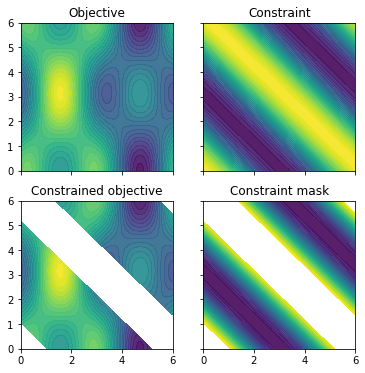

In [4]:
util.plot_objective_and_constraints(sim)
plt.show()

We'll make an observer that outputs the objective and constraint data, labelling each as shown.

In [5]:
OBJECTIVE = "OBJECTIVE"
CONSTRAINT = "CONSTRAINT"

def observer(query_points):
    return {
        OBJECTIVE: trieste.datasets.Dataset(query_points, sim.objective(query_points)),
        CONSTRAINT: trieste.datasets.Dataset(query_points, sim.constraint(query_points))
    }

Let's randomly sample some initial data from the observer ...

In [6]:
initial_data = observer(search_space.sample(5))

... and visualise those points on the constrained objective.

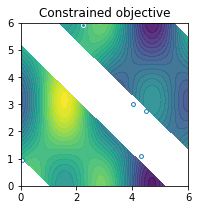

In [7]:
util.plot_init_query_points(
    sim, astuple(initial_data[OBJECTIVE]), astuple(initial_data[CONSTRAINT])
)
plt.show()

## Modelling the two functions

We'll model the objective and constraint data with their own Gaussian process regression models.

In [8]:
def create_bo_model(data):
    variance = tf.math.reduce_variance(initial_data[OBJECTIVE].observations)
    lengthscale = 1.0 * np.ones(2, dtype=default_float())
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=lengthscale)
    gpr = gpflow.models.GPR(astuple(data), kernel, noise_variance=1e-5)
    set_trainable(gpr.likelihood, False)
    return trieste.models.create_model_interface(
        {
            "model": gpr,
            "optimizer": gpflow.optimizers.Scipy(),
            "optimizer_args": {"options": dict(maxiter=100)},
        }
    )

models = {
    OBJECTIVE: create_bo_model(initial_data[OBJECTIVE]),
    CONSTRAINT: create_bo_model(initial_data[CONSTRAINT])
}

## Define the acquisition process

We can construct the _expected constrained improvement_ acquisition function defined in
Gardner, 2014 [1], where they use the probability of feasibility wrt the constraint model.

In [9]:
class ExpectedFeasibleImprovement(trieste.acquisition.rule.AcquisitionFunctionBuilder):
    MIN_PROBABILITY = 0.5
    PENALIZATION = 1.1

    def __init__(self, constraint_builder):
        self._constraint_builder = constraint_builder

    def prepare_acquisition_function(self, datasets, models):
        mean, _ = models[OBJECTIVE].predict(datasets[OBJECTIVE].query_points)

        pof_fn = self._constraint_builder.prepare_acquisition_function(datasets, models)

        pof = pof_fn(datasets[OBJECTIVE].query_points)
        onehot = tf.cast(pof < self.MIN_PROBABILITY, mean.dtype)
        dist = tf.reduce_max(mean) - tf.reduce_min(mean)
        penalization = self.PENALIZATION * dist * onehot
        eta = tf.reduce_min(mean + penalization, axis=0)

        ei_fn = lambda at: trieste.acquisition.expected_improvement(models[OBJECTIVE], eta, at)
        return lambda at: ei_fn(at) * pof_fn(at)


pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=sim.threshold)
eci = ExpectedFeasibleImprovement(pof.using(CONSTRAINT))
rule = trieste.acquisition.rule.EfficientGlobalOptimization(eci)

## Run the optimization loop

We can now run the optimization loop

In [10]:
num_steps = 20
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

result = bo.optimize(num_steps, initial_data, models, acquisition_rule=rule)

if result.error is not None: raise result.error

To conclude, we visualise the resulting data. Orange dots show the new points queried during
optimization. Notice the concentration of these points in regions near the local minima.

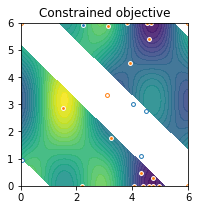

In [11]:
constraint_data = result.datasets[CONSTRAINT]
new_data = (
    constraint_data.query_points[-num_steps:], constraint_data.observations[-num_steps:]
)

util.plot_init_query_points(
    sim, astuple(initial_data[OBJECTIVE]), astuple(initial_data[CONSTRAINT]), new_data
)
plt.show()

## References

```
[1] @inproceedings{gardner14,
      title={Bayesian Optimization with Inequality Constraints},
      author={Jacob Gardner and Matt Kusner and Zhixiang and Kilian Weinberger and John Cunningham},
      booktitle={Proceedings of the 31st International Conference on Machine Learning},
      year={2014},
      volume={32},
      number={2},
      series={Proceedings of Machine Learning Research},
      month={22--24 Jun},
      publisher={PMLR},
      url={http://proceedings.mlr.press/v32/gardner14.html},
    }
```